In [1]:
%matplotlib inline

In [ ]:
# Load FS example data
from arpes.io import load_data
f = load_data('FS_AN_25eV_CIRCP_0000.h5', location="ULTRA")

C:\Users\hellbrue\Documents\Repositories\pyarpes\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


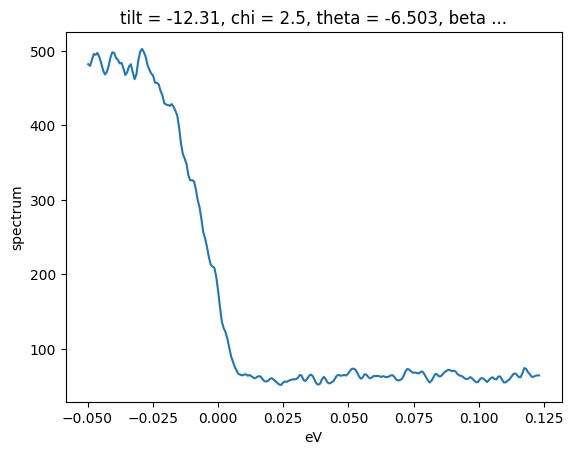

In [16]:
sls_edc = f.spectrum.sel(eV=slice(-0.05,None), phi=slice(-5,5)).sum("phi").isel(tilt=10)

sls_edc.plot()

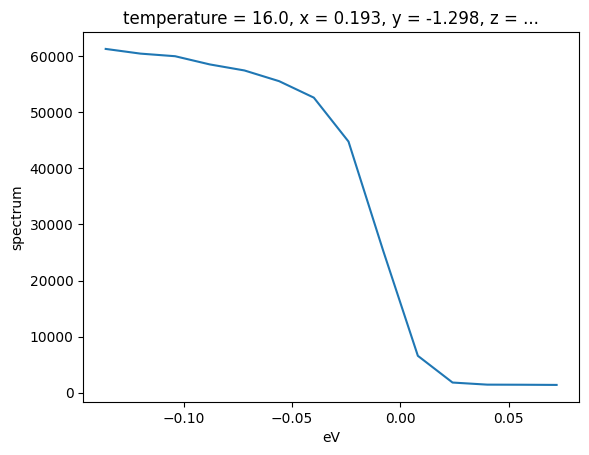

In [6]:
# first let's prepare some data to curve fit
from arpes.io import example_data

test_edc = example_data.temperature_dependence.spectrum.sel(
    eV=slice(-0.15, None)).sum("phi").isel(temperature=0)

test_edc.plot()

C:\Users\hellbrue\Documents\Repositories\pyarpes\arpes\fits\fit_models\fermi_edge.py:57: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)


name,value,min,max,stderr,vary,expr,brute_step
const_bkg,389.738,-inf,inf,12585.619,True,,
conv_width,0.009,0.000,inf,0.016,True,,
fd_center,-0.006,-inf,inf,12.262,True,,
fd_width,0.000,0.000,inf,4.322,True,,
lin_bkg,-1025.315,-inf,inf,832.416,True,,
offset,61.465,0.000,inf,0.682,True,,


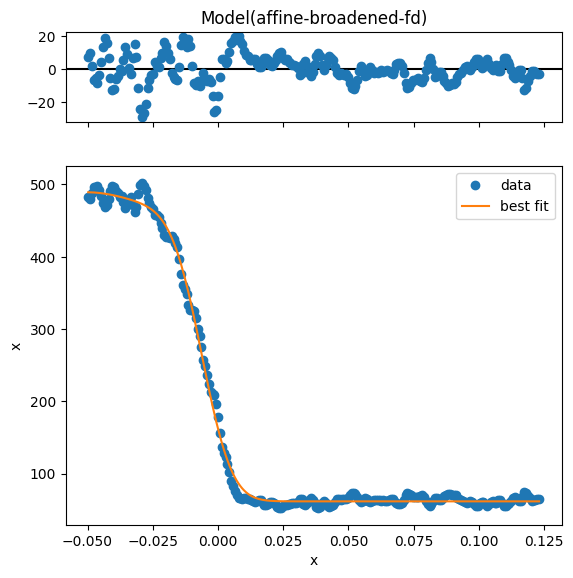

In [17]:
from arpes.fits.fit_models import AffineBroadenedFD

sls_result = AffineBroadenedFD().guess_fit(sls_edc)
sls_result.plot()
sls_result

name,value,min,max,stderr,vary,expr,brute_step
const_bkg,50944.681,-inf,inf,1068.999,True,,
conv_width,0.008,0.000,inf,0.006,True,,
fd_center,-0.009,-inf,inf,0.000,True,,
fd_width,0.008,0.000,inf,0.003,True,,
lin_bkg,-77394.660,-inf,inf,9882.491,True,,
offset,1163.460,0.000,inf,321.408,True,,


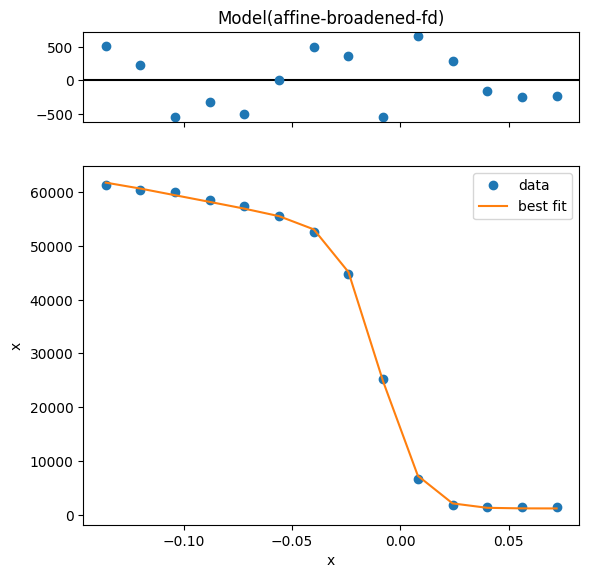

In [7]:
from arpes.fits.fit_models import AffineBroadenedFD

result = AffineBroadenedFD().guess_fit(test_edc)
result.plot()    # plot the fit, residual, etc
result           # print parameters and info

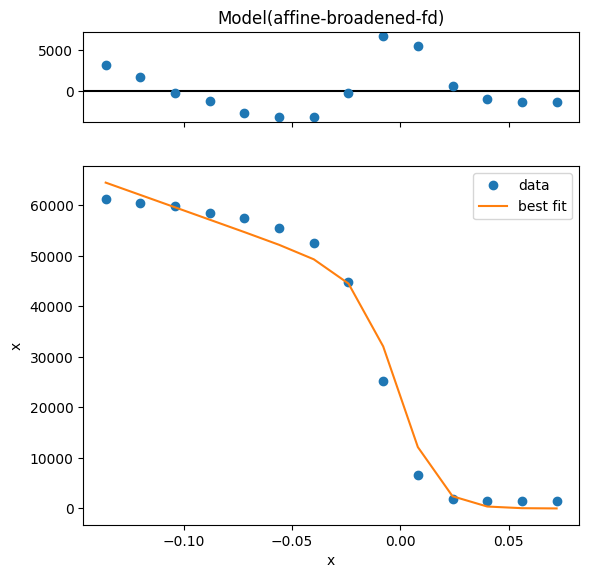

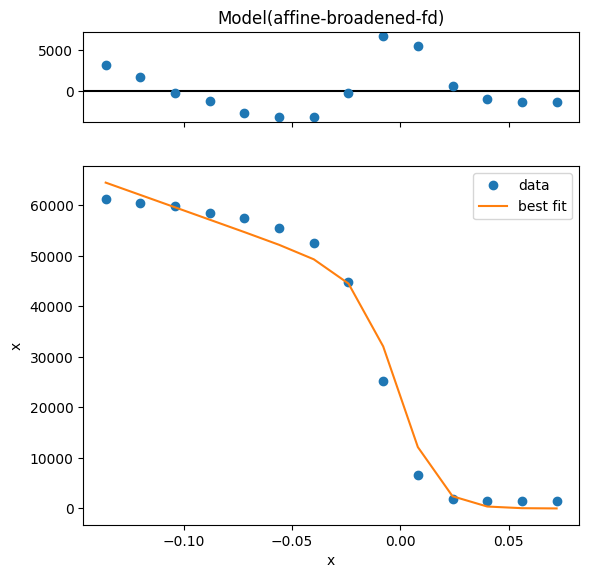

In [24]:
AffineBroadenedFD().guess_fit(
    test_edc, params={"fd_center": {
        "value": 0.00010, # set the initial guess to 5meV
        "vary": False   # do not vary this parameter
    }}
).plot()

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/34 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


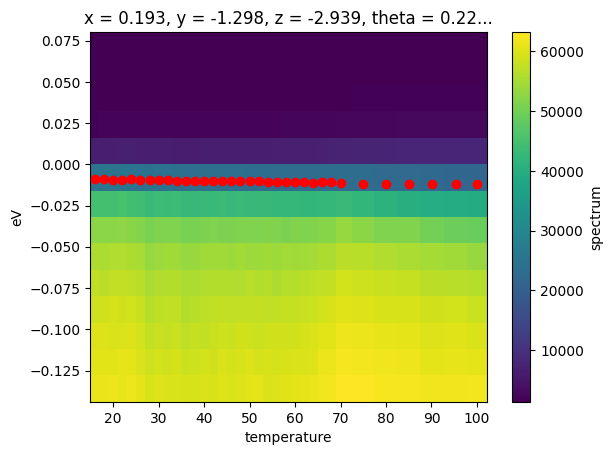

In [27]:
from arpes.fits.utilities import broadcast_model
import matplotlib.pyplot as plt

temp_edcs = example_data.temperature_dependence.sel(
    eV=slice(-0.15, None)).sum("phi").spectrum

fit_results = broadcast_model(
    AffineBroadenedFD,  # <- fit this model class
    temp_edcs,          # <- on this dataset
    "temperature",      # <- by iterating across slices of this variable
                        #    or variables
    params={"conv_width": {"value": 0, "vary": False}}
)

temp_edcs.T.plot()
plt.scatter(*fit_results.F.p("fd_center").G.to_arrays(), color="red")

(16.0, 99.98)

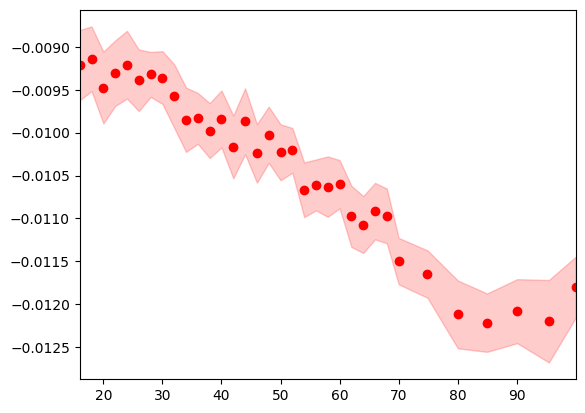

In [28]:
p, s = fit_results.F.p("fd_center"), fit_results.F.s("fd_center")

fig, ax = plt.subplots()
ax.fill_between(fit_results.temperature.values, p-s, p+s, color="red", alpha=0.2)
ax.scatter(fit_results.temperature.values, p, color="red")

ax.set_xlim(fit_results.temperature.values[[0, -1]])

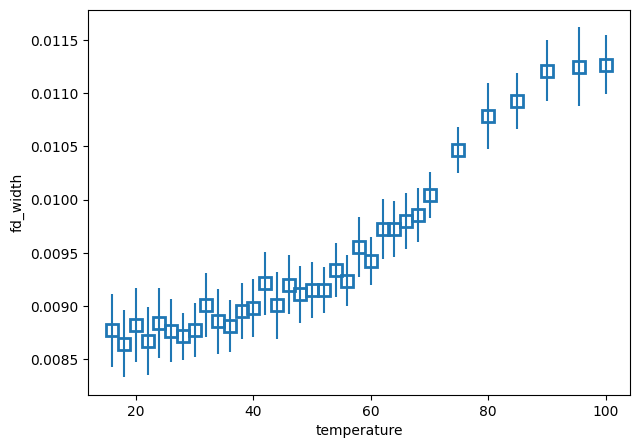

In [29]:
from arpes.config import use_tex
use_tex()
fit_results.F.plot_param("fd_width")

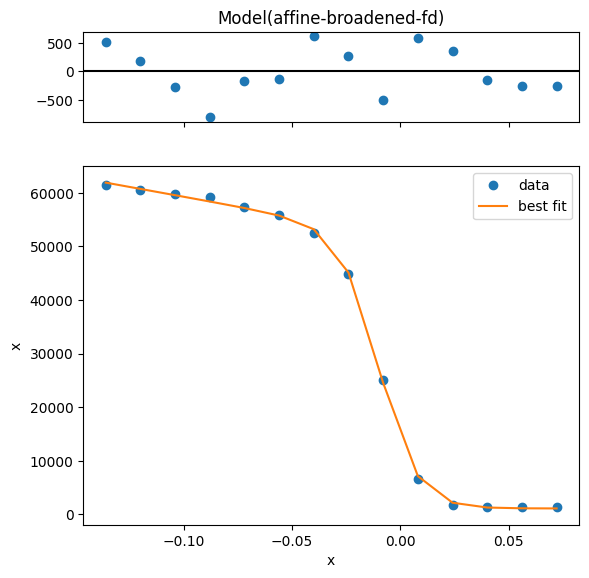

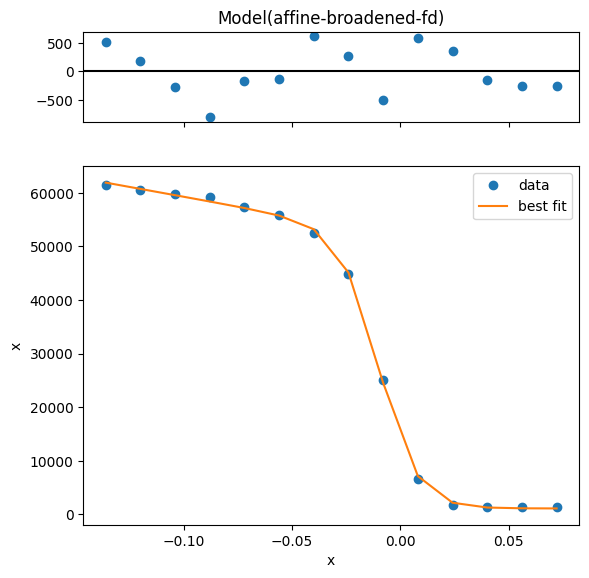

In [31]:
worst_fit = fit_results.F.worst_fits()[0].item()
worst_fit.plot()

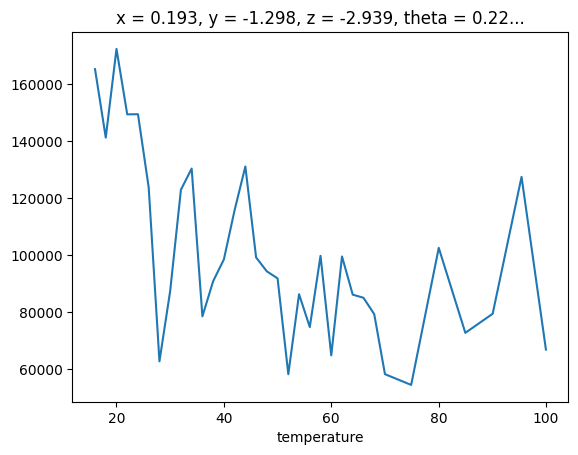

In [32]:
fit_results.F.mean_square_error().plot()